In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [2]:
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [15]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [16]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

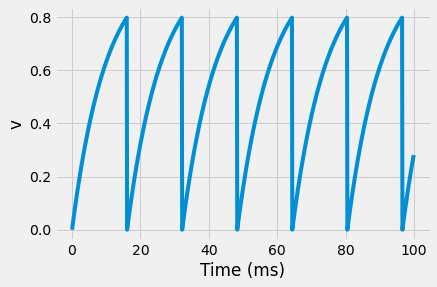

In [17]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

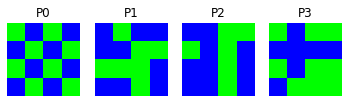

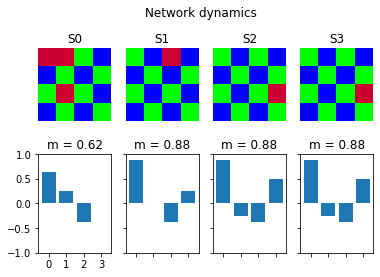

In [24]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=3, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=3)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

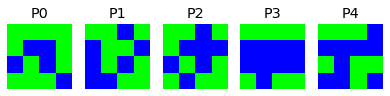

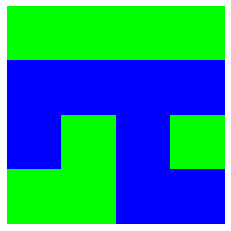

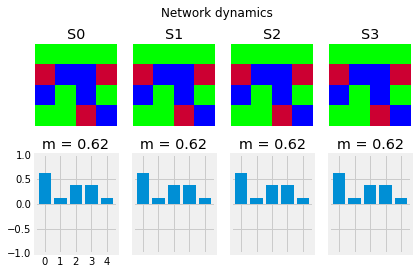

In [40]:
plist = get_patterns(4,5)
#plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)

S = perturb_pattern(cue[0],3)
wghts = calculate_weights(plist, pattern_size)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    state_list.append(network_evolution(S,wghts))
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

# QUESTION 1


After going through [this](https://neuronaldynamics.epfl.ch/online/Ch17.S2.html), I learnt that we can actually use two ways to create our hopefields network. One of them is the standard method in which weights are calculated and the given test state is evolved accordingly. The other method does not need any calculation of weights, but can be directly calculated with the help of overlap between memory patterns and the given test pattern. Mathematically, the final equations are same in both the cases. Hence, I tried to write codes for both of them. 


In [44]:
import numpy as np
import copy
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
def pattern_generate (num_of_patterns,size_of_pattern):
    plist = []
    for p in range(num_of_patterns):
        neurons = np.array([[0]*size_of_pattern]*size_of_pattern)
        for i in range(size_of_pattern):
            for j in range(size_of_pattern):
                x = np.random.rand()
                if(x>0.5):
                    neurons[i][j] = 1   
                else:
                    neurons[i][j] = -1    
        plist.append(neurons)
    return plist

def calculate_weights(pattern_list, size_of_pattern):
    weights = np.array([[0]*size_of_pattern**2]*size_of_pattern**2)
    for p in range(len(pattern_list)):
        for i in range(size_of_pattern**2):
            for j in range(size_of_pattern**2):
                weights[i][j] += pattern_list[p][i//size_of_pattern][i%size_of_pattern]*pattern_list[p][j//size_of_pattern][j%size_of_pattern]
    return weights/size_of_pattern**2


def overlap_calculation (plist, state):
    overlap = []
    for p in range(len(plist)):
        m = 0
        for i in range(len(state)):
            for j in range(len(state)):
                m += plist[p][i][j]*state[i][j]     
        m = float(m)/len(state)**2        
        overlap.append(m)
    return overlap    
                      

def perturb_pattern (pattern, flips, size_of_pattern):
    locs = np.random.randint(0,size_of_pattern**2-1,flips)
    for f in locs:
        i = int(f/len(pattern))
        j = f%len(pattern)
        pattern[i][j] = - pattern[i][j]
    return pattern




#### METHOD 1


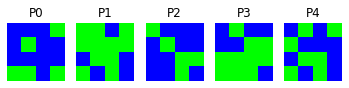

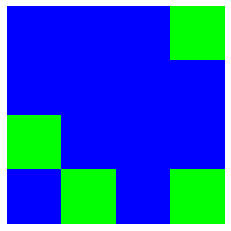

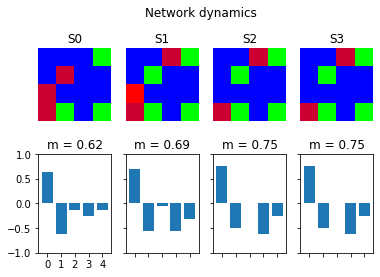

In [43]:
def network_evolution(state, weights):
    updated = copy.deepcopy(state)
    for i in range(len(weights)):
        temp = 0
        for j in range(len(weights)):
            temp += weights[i][j]*updated[j//len(state)][j%len(state)]
        updated[i//len(state)][i%len(state)] = np.sign(np.sum(temp))
    return updated


plist = pattern_generate(5,4)
cue = copy.deepcopy(plist)
S = perturb_pattern(cue[0],3,4)
wghts = calculate_weights(plist, 4)

state_list =[S]

for i in range(3):
    S = network_evolution(S,wghts)
    state_list.append(S)


plot_tools.plot_pattern_list(plist)
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

#### METHOD 2

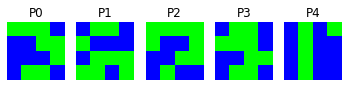

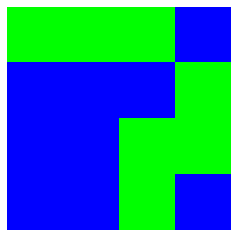

overlap with memory patterns is as following:
[0.75, 0.125, 0.625, 0.625, -0.375]



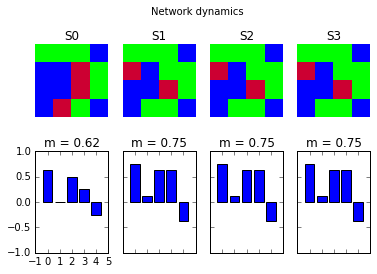

In [50]:
def hopesfield(plist,overlap,size_of_pattern):
    update = np.array([[0]*size_of_pattern]*size_of_pattern)
    hello = copy.deepcopy(plist)
    for p in range(len(plist)):
        hello[p] = plist[p]*overlap[p]
    for i in range(size_of_pattern):   
        for j in range(size_of_pattern):
            updated_neuron = 0
            for p in range(len(hello)):
                updated_neuron += hello[p][i][j]
            if(updated_neuron>=0):
                update[i][j] = 1
            else:
                update[i][j] = -1            
    return update


pattern_list = pattern_generate(5,4)
plot_tools.plot_pattern_list(pattern_list)
cue = copy.deepcopy(pattern_list)
S = perturb_pattern(cue[0],3,4)
plot_tools.plot_pattern(S)
state_list =[S]

for i in range(3):
    overlap = overlap_calculation(pattern_list,S)
    S = hopesfield(pattern_list,overlap,4)
    state_list.append(S)
    
final_overlap = overlap_calculation(pattern_list,S)
print("overlap with memory patterns is as following:")
print(final_overlap)
plot_tools.plot_state_sequence_and_overlap(state_list, pattern_list, reference_idx=0, suptitle="Network dynamics")

# QUESTION 2

Informativeness of the cue: 
It is clear from the graphs given below, as the noise(no of flips) increases in cue, the network's abi

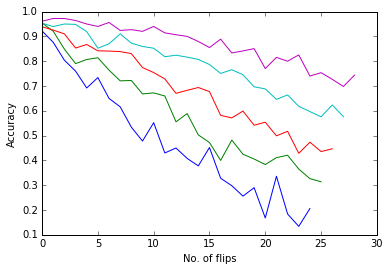

In [86]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

for i in range(5,10):
    x = []
    y = []
    for j in range(0,i+20):
        x.append(j)
        output = []
        for sample in range(40):
            pattern_list = pattern_generate(20,i)
            cue = copy.deepcopy(pattern_list)
            S = perturb_pattern(cue[0],j,i)
            for k in range(10):
                overlap = overlap_calculation(pattern_list,S)
                S = hopesfield(pattern_list,overlap,i)
            overlap = overlap_calculation(pattern_list,S)
            output.append(overlap[0])
        final = np.mean(output)
        y.append(final)
    
    plt.plot(x, y)
    plt.xlabel('No. of flips')
    plt.ylabel('Accuracy')
  

Number of patterns: For a given number of flips ( here flips = 5) and for a given number of neurons( here I have taken neurons = 25), We can see from the graph that as the number of patterns increases, accuracy decreases. However it is interesting to note that the rate of decrease of accuracy is not that large.

[25, 36, 49, 64, 81, 100, 121, 144, 169, 196]
[0.8832162439421275, 0.879329008858199, 0.8741851507961073, 0.869704585537919, 0.8661313526715515, 0.8620119495609692, 0.8579220821525131, 0.8533658050411521, 0.8495950363388238, 0.8459453531365545]


Text(0, 0.5, 'Accuracy')

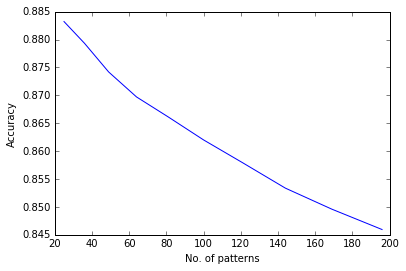

In [102]:
x = []
y = []
for i in range(5,15):
    x.append(i**2)
    for sample in range(40):
        pattern_list = pattern_generate(i**2,5)
        cue = copy.deepcopy(pattern_list)
        S = perturb_pattern(cue[0],7,5)
        for k in range(10):
            overlap = overlap_calculation(pattern_list,S)
            S = hopesfield(pattern_list,overlap,5)
        overlap = overlap_calculation(pattern_list,S)
        output.append(overlap[0])
    final = np.mean(output)
    y.append(final)
print(x)
print(y)
plt.plot(x, y)
plt.xlabel('No. of patterns')
plt.ylabel('Accuracy')
    

Size of the network: For given number of memory patterns ( I have taken it to be 5), accuracy increases with increase in number of neurons (for constant number of flips)( Which is somewhat obvious since percentage of corruption/noise will decrease with increase in number of neurons.)

Text(0, 0.5, 'Accuracy')

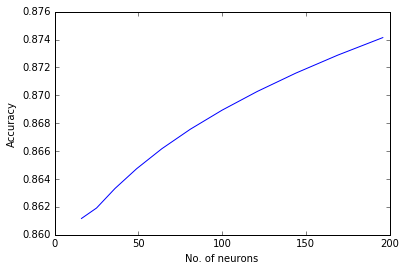

In [104]:
x = []
y = []
for N in range(4,15):
    x.append(N**2)
    for sample in range(40):
        pattern_list = pattern_generate(5,N)
        cue = copy.deepcopy(pattern_list)
        S = perturb_pattern(cue[0],4,N)
        for k in range(10):
            overlap = overlap_calculation(pattern_list,S)
            S = hopesfield(pattern_list,overlap,N)
        overlap = overlap_calculation(pattern_list,S)
        output.append(overlap[0])
    final = np.mean(output)
    y.append(final)
    
plt.plot(x, y)
plt.xlabel('No. of neurons')
plt.ylabel('Accuracy')
    
    

# QUESTION 3

In [2]:
from keras.datasets import mnist


Using TensorFlow backend.


In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


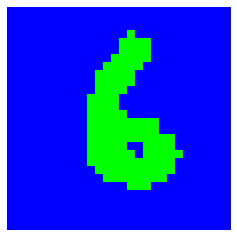

In [90]:
import numpy as np
plist = []
y = []
for i in range(1000):
    x = train_X[i].flatten()
    x=np.where(x<128,-1,1)
    x = np.reshape(x,(-1,28))
    plist.append(x)
    y.append(train_y[i])
#Let us generate a random number from the data in the form of pattern as used in question 1 and 2    
plot_tools.plot_pattern(plist[36])


# QUESTION 4

We can easily see that Hopfield is a very bad multi classifier with accuracy of around 20-35%. On the other hand, CNN can achieve almost 99% accuracy. Linear models are also far better than Hopefield network with accuracy of around 80-90%.
The major disadvantage of hopefields network is that you can not train 60000 data sample available in MNIST since the number of neurons is just 28*28 = 784. 
It is, therefore, not a good learning model.
It however can be used as binary classifier .No matter what the test sample is, the model, for most of the time, predicts it as either 1 or 4.  

In [92]:
weights = calculate_weights(plist, 28)

In [93]:
#let us try to predict first 30 samples from the test data. 
y_predict = []
for i in range(30):
    S = test_X[i].flatten()
    S=np.where(S<128,-1,1)
    S = np.reshape(S,(-1,28))
    for j in range(3):
        S = network_evolution(S,weights)
    overlap = overlap_calculation(plist,S)
    index = np.argmax(overlap)
    y_predict.append(train_y[index])


In [94]:
#accuracy check for 30 test samples with 1000 corresponding training data
j = 0
for i in range(30):
    if y_predict[i]==test_y[i]:
        j=j+1
accuracy = j/20        

In [95]:
accuracy

0.35

In [105]:
#let us try to predict next 30 samples from the test data. 
y_predict = []
for i in range(30):
    S = test_X[i+30].flatten()
    S=np.where(S<128,-1,1)
    S = np.reshape(S,(-1,28))
    for j in range(3):
        S = network_evolution(S,weights)
    overlap = overlap_calculation(plist,S)
    index = np.argmax(overlap)
    y_predict.append(train_y[index])

In [109]:
#accuracy check for next 30 test samples with 1000 corresponding training data
j = 0
y_true = []
for i in range(30):
    y_true.append(test_y[1])
    if y_predict[i]==test_y[i+30]:
        j=j+1
accuracy = j/20  

In [110]:
y_predict

[4,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 1,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 1]

In [111]:
accuracy

0.35